# AppStat 2023 Project

## Group Members
- Andras
- Ellen
- Oscar
- Pernille
- Rasmine 

## Error propagation
Error propagation the local acceleration due to gravity _g_ using a pendulum and a slope experiment.

In [122]:
from IPython.core.display import Latex

def lprint(*args,**kwargs):
    """Pretty print arguments as LaTeX using IPython display system 
    
    Parameters
    ----------
    args : tuple 
        What to print (in LaTeX math mode)
    kwargs : dict 
        optional keywords to pass to `display` 
    """
    display(Latex('$$'+' '.join(args)+'$$'),**kwargs)

In [123]:
# Import SymPy: 
from sympy import * 
    
# Define variables:
L,T,theta,R,d, gp, gs,a = symbols("L, T, theta, R, d, g_pendulum, g_slope,a")
dL,dT,dth,dR,dd,dgp,dgs,da = symbols("sigma_L, sigma_T, sigma_theta, sigma_r, sigma_d, sigma_gP,sigma_gS,sigma_a")

# Pendulum:
# Define relation, and print:
gp = L * (2 * pi / T)**2 
lprint(latex(Eq(symbols('g_pendulum'),gp)))

# Calculate uncertainty and print:
dgp = sqrt((gp.diff(L) * dL)**2 + (gp.diff(T) * dT)**2)
lprint(latex(Eq(symbols('sigma_gP'), dgp)))

# Turn expression into numerical functions 
fP = lambdify((L,T),gp)
fdP = lambdify((L,dL,T,dT),dgp)

# Define values and their errors
# vL, vdL = mu1,sig1
# vT, vdT = mu2,sig2

vL, vdL = 1.5,0.2
vT, vdT = 3,0.5


# Numerically evaluate expressions and print 
vP = fP(vL,vT)
vdP = fdP(vL,vdL,vT,vdT)
lprint(fr'g = ({vP:.3f} \pm {vdP:.3f})\,\mathrm{{m/s^2}}')

# Pendulum:
# Define relation, and print:
gs = a/sin(theta) * (1+2/5 * R**2 / (R**2-(d/2)**2)) 
lprint(latex(Eq(symbols('g_slope'),gs)))

# Calculate uncertainty and print:
dgs = sqrt((gs.diff(a) * da)**2 + (gs.diff(theta) * dth)**2+ (gs.diff(R) * dR)**2+ (gs.diff(d) * dd)**2)
lprint(latex(Eq(symbols('sigma_gS'), dgs)))

# Turn expression into numerical functions 
fP = lambdify((a,theta,R,d),gs)
fdP = lambdify((a,da,theta,dth,R,dR,d,dd),dgs)

# Define values and their errors
# vL, vdL = mu1,sig1
# vT, vdT = mu2,sig2
va,vtheta,vR,vd = 6.2, 30, 5, 5.0

vda,vdtheta,vdR,vdd = 0.2, 2, 0.2, 0.1

# Numerically evaluate expressions and print 
vP = fP(va,vtheta,vR,vd)
vdP = fdP(va,vda,vtheta,vdtheta,vR,vdR,vd,vdd)
lprint(fr'g = ({vP:.3f} \pm {vdP:.3f})\,\mathrm{{m/s^2}}')



# NOTE: Do the above analytical calculation before you continue below! Possibly use SymPy for the differentiations.

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Pendulum
- Pendulum length: Measured both with measuring tape and laser.
- Pendulum period: Measured over several (e.g. 25+) swings.
- Pendulum timing precisions: Accuracy of timing of each team member 

In [124]:
import numpy as np     
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab   
from scipy import stats                             # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories


sys.path.append('External_Functions')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax 



r = np.random                         # Random generator
r.seed(42)  


In [125]:

#periods = np.array([[],[],[],[],[]])

pend_1  = np.loadtxt('Data/oscar_2.dat', delimiter='\t')
pend_2  = np.loadtxt('Data/pernille_2.dat', delimiter='\t')
pend_3  = np.loadtxt('Data/andras_1.dat', delimiter='\t')
pend_4  = np.loadtxt('Data/ellen1.dat', delimiter='\t')
pend_5  = np.loadtxt('Data/ras_1.dat', delimiter='\t')

Names = ['Oscar','Pernille','Andras','Ellen','Ras']
#print(periods.shape)
#for i in range(2,5):
#    periods[i] = periods[i]*(np.arange(25)+1)+ r.normal(0, 0.033, 25)

#periods[0] = pend_1[:-1,1]
#periods[1] = pend_2[:-1,1]
#periods[2] = pend_3[:-1,1]
#periods[3] = pend_4[:-1,1]
#periods[4] = pend_5[:-1,1]

periods = np.array([pend_1[:,1],pend_2[:,1],pend_3[:,1],pend_4[:,1],pend_5[:,1]])



C:\Users\rasmi\AppData\Local\Temp\ipykernel_26284\1431388592.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  periods = np.array([pend_1[:,1],pend_2[:,1],pend_3[:,1],pend_4[:,1],pend_5[:,1]])


In [126]:


# Define the linear model
def linear_model(x, a, b):
    return a * x + b

# Gaussian function for fitting
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean)**2) / (2 * stddev**2))



# Calculate the residuals
def calculate_rms_residuals(x_data, y_data, fit_params):
    residuals = y_data - linear_model(x_data, *fit_params)
    return np.sqrt(np.mean(residuals**2))


In [127]:

N_measurements = 25
N_exp = 5
x_data = np.arange(N_measurements)+1
N_bins = 25


Pendulum_Slope = np.zeros(N_exp)
Pendulum_Mean = np.zeros(N_exp)
Pendulum_Chi2 = np.zeros(N_exp)
Pendulum_Prob = np.zeros(N_exp)

residuals =list()

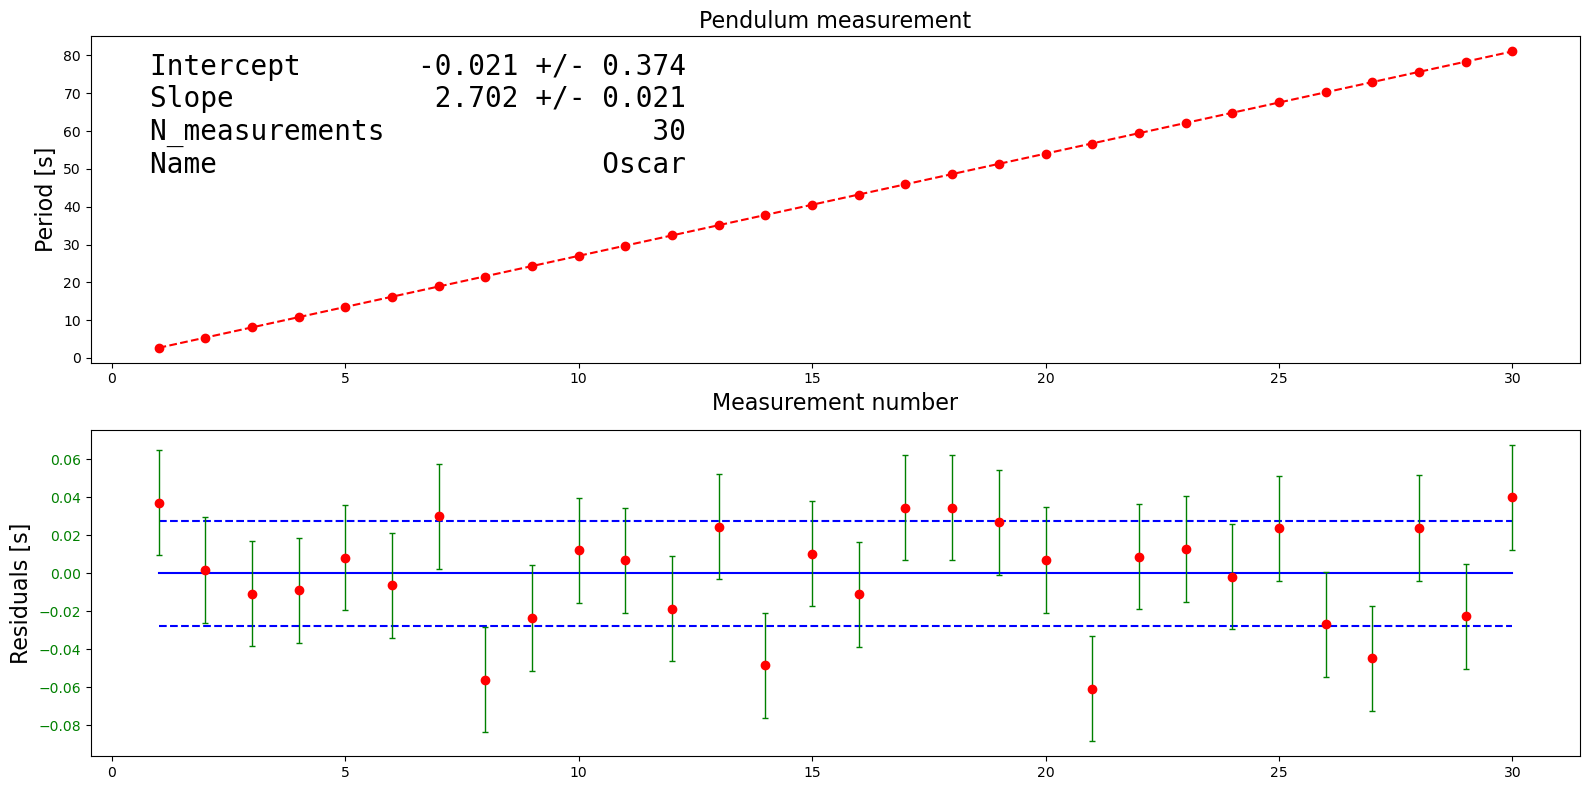

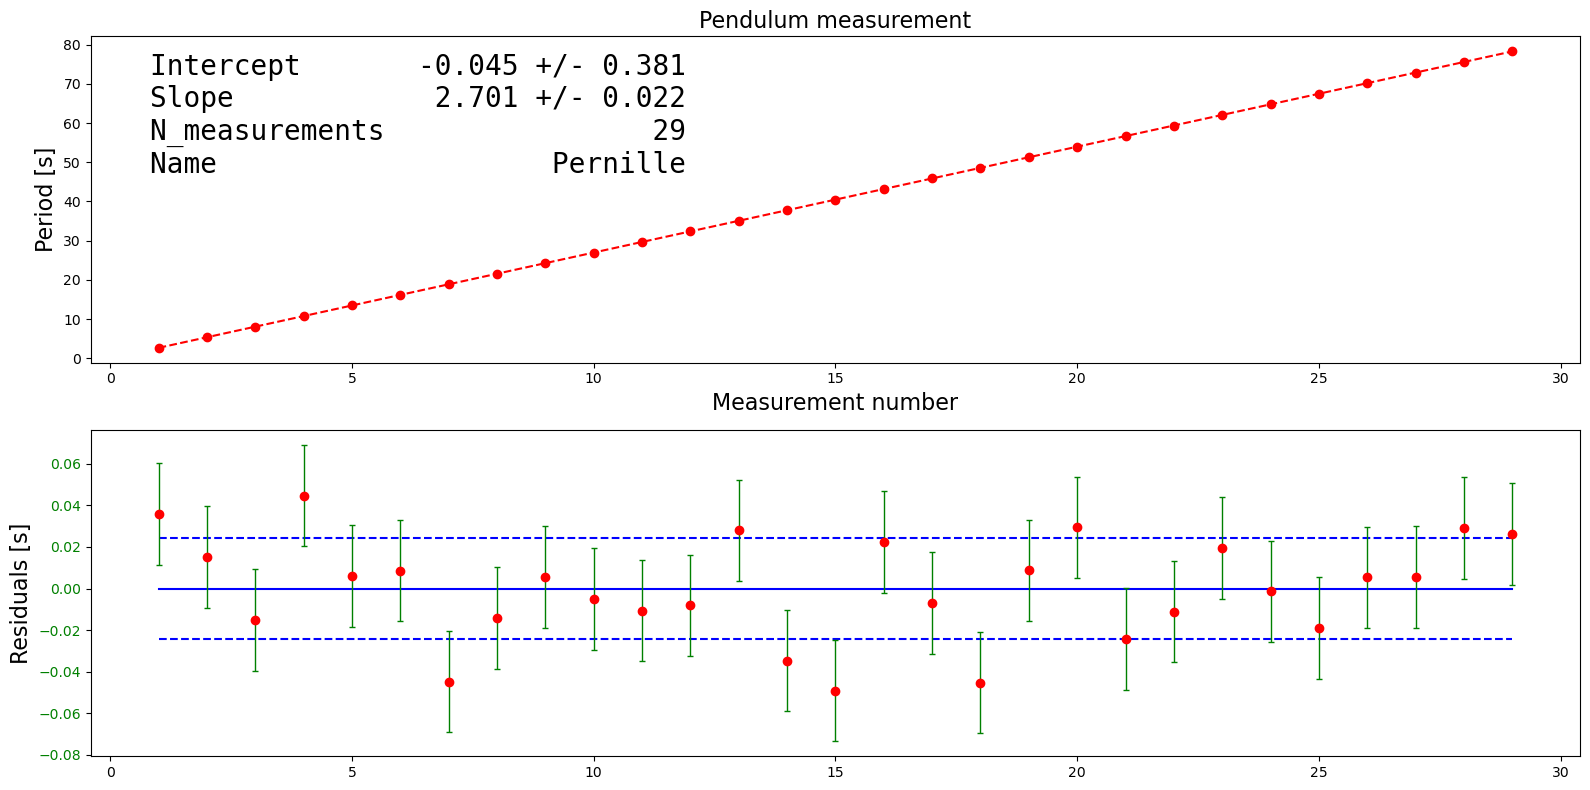

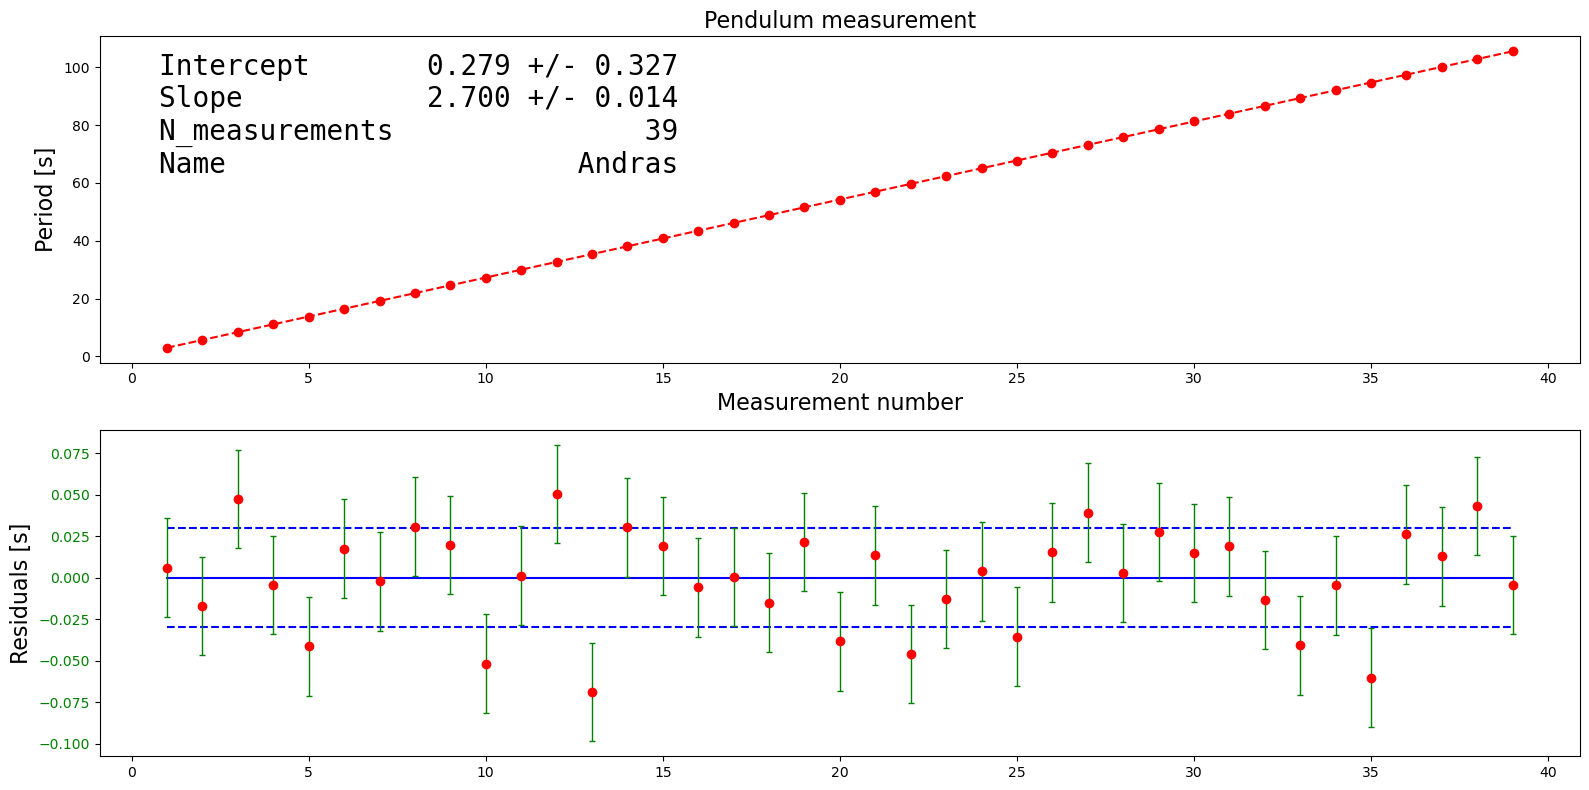

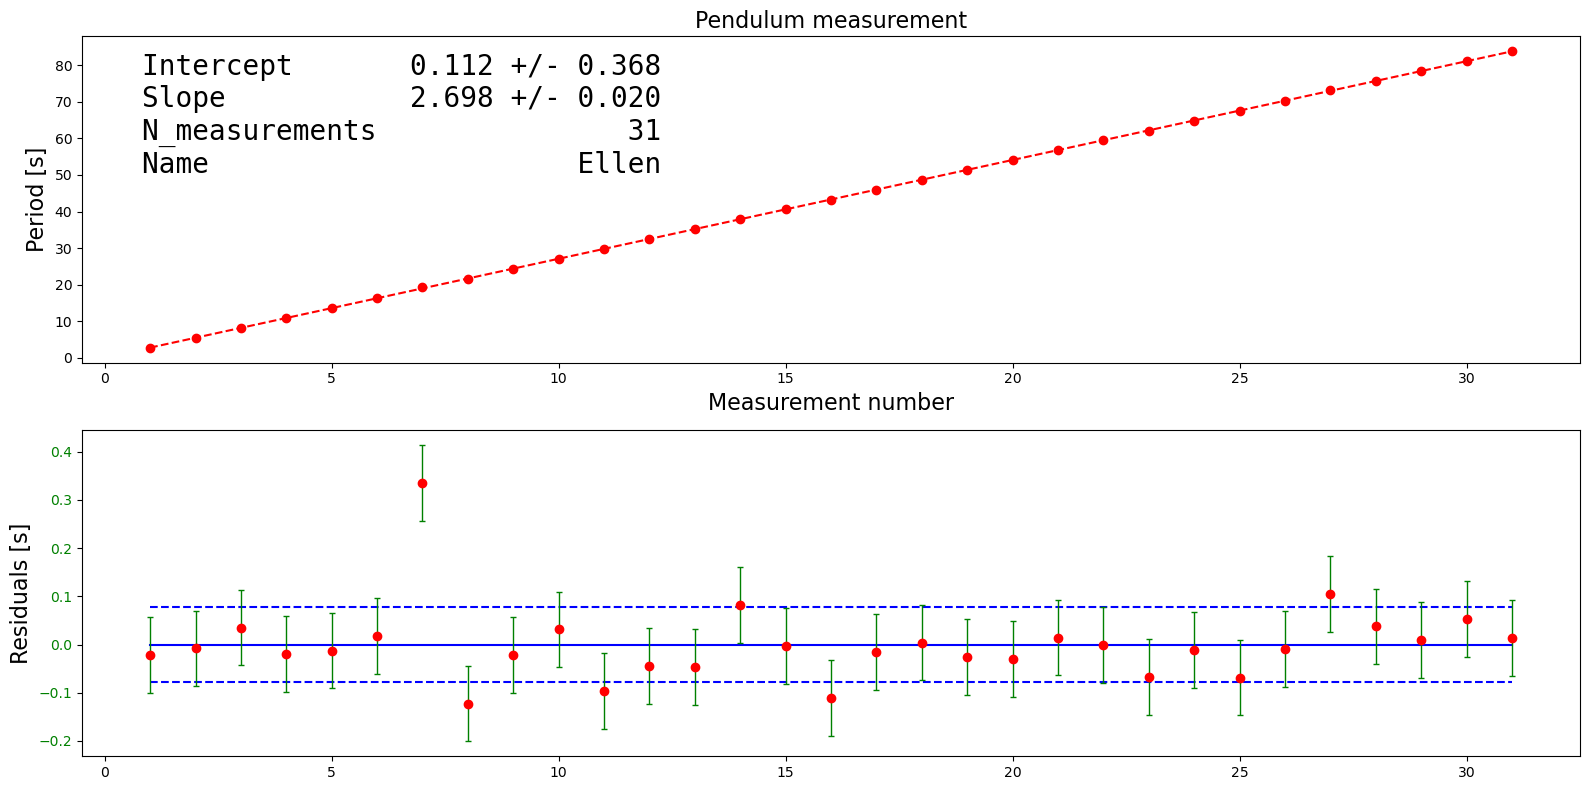

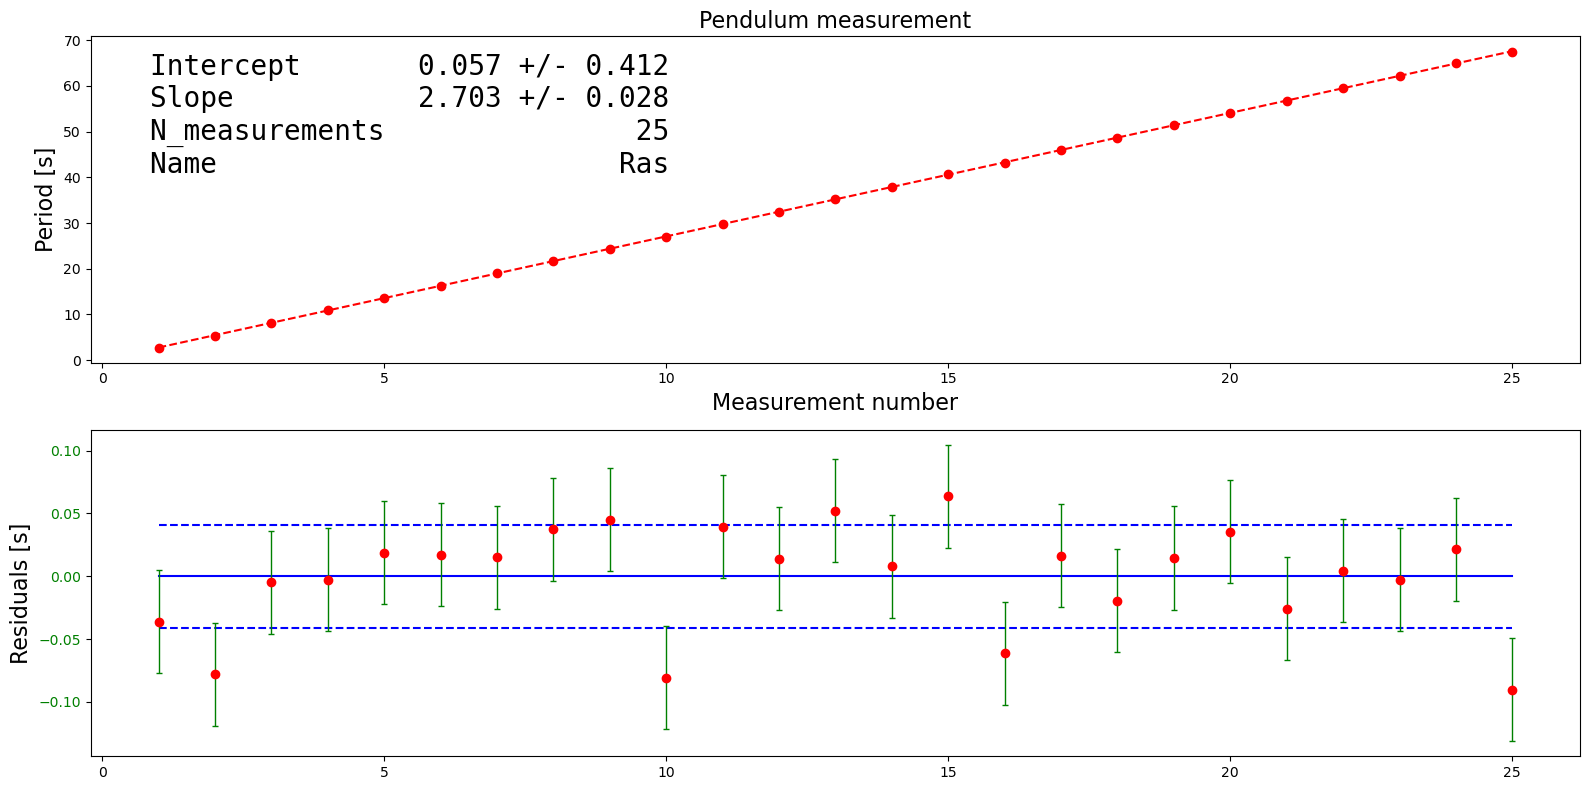

In [128]:
for iexp in range(N_exp):
    N_measurements = len(periods[iexp])
    x_data = np.arange(N_measurements)+1
    
    chi2_object = Chi2Regression(linear_model, x_data, periods[iexp])
    m = Minuit(chi2_object,a=7.5,b=0)
    m.migrad()

    Chi2Lin = m.fval # the chi2 value
    NvarLin = 2                      # Number of variables (alpha0 and alpha1)
    NdofLin = N_measurements - NvarLin   # Number of degrees of freedom
    ProbLin =  stats.chi2.sf(Chi2Lin, NdofLin) # The chi2 probability given N_DOF degrees of freedom
    
    Pendulum_Chi2[iexp] = Chi2Lin
    Pendulum_Prob[iexp] = ProbLin


    residual = periods[iexp] - linear_model(x_data, m.values['a'], m.values['b'])
    residuals.append(residual)
    
    
    mean, stddev = stats.norm.fit(residual)

    
    fig, axes = plt.subplots(nrows=2, figsize=(16, 8))
    ax=axes[0]
    ax.errorbar(x_data, periods[iexp],0.033, fmt='ro', ecolor='b', elinewidth=1, capsize=2, capthick=1)
    ax_res = axes[1]
    
    ax.plot(x_data, linear_model(x_data, *m.values[:]), '--r')
    
    ax.set_xlabel('Measurement number', fontsize=16)
    ax.set_ylabel('Period [s]', fontsize=16)
    ax.set_title('Pendulum measurement', fontsize=16)


    ax_res.plot(x_data, np.zeros_like(x_data), '-b')
    ax_res.plot(x_data, np.full_like(x_data,stddev,dtype=float), '--b')
    ax_res.plot(x_data, np.full_like(x_data,-stddev,dtype=float), '--b')

    ax_res.errorbar(x_data, residual,stddev, fmt='ro', ecolor='g', elinewidth=1, capsize=2, capthick=1)
    # set ax_res to only fill the botoom quarter of the figure 
    ax_res.set_ylabel('Residuals [s]', fontsize=16)
    ax_res.tick_params(axis='y', labelcolor='g')



    d = {'Intercept':[m.values['b'], m.errors['b']],
        'Slope':    [m.values['a'], m.errors['a']],
        'N_measurements': N_measurements,
        'Name': Names[iexp]
        }
    
    Pendulum_Slope[iexp] = m.values['a']


    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.04, 0.95, text, ax, fontsize=20)
    

    fig.tight_layout()






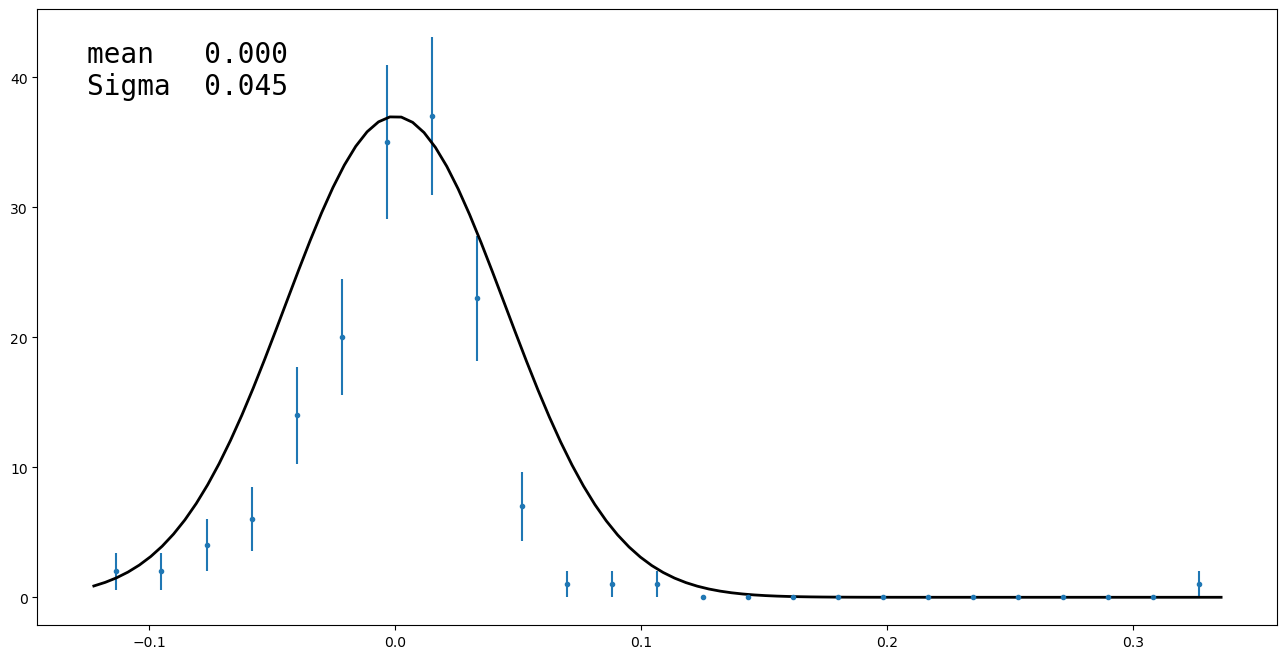

In [129]:
residuals = np.hstack(residuals)

y, bin_edges = np.histogram(residuals, bins=N_bins)
x = 0.5*(bin_edges[:-1] + bin_edges[1:])
sy = np.sqrt(y) 
mean, stddev = stats.norm.fit(residuals)

x_gauss = np.linspace(min(residuals), max(residuals), 100)

fig, ax = plt.subplots(figsize=(16, 8))
hist = ax.errorbar(x, y, sy, fmt='.')
ax.plot(x_gauss, gaussian(x_gauss, max(y), mean, stddev), 'k', linewidth=2)

dd = {'mean':mean,
    'Sigma':stddev,
    }
text2 = nice_string_output(dd, extra_spacing=2, decimals=3)
add_text_to_ax(0.04, 0.95, text2, ax, fontsize=20)

In [130]:
# Data from length meassurements

top_pend = np.array([179.9,180.1,180.1,179.9,180.0])
top_pend_sigma = np.array([3,2,2,0.5,0.1])*0.01
heigth_pend = np.array([2.50,2.50,2.5,2.50,2.50])
heigth_pend_sigma = np.array([0.5,0.2,0.5,0.1,0.2])*0.01
start_floor_pend = np.array([23.8,23.6,23.7,23.7,23.8])
start_floor_pend_sigma = np.array([2,1,1.5,0.5,1])*0.01
End_floor_pend = np.array([23.8,23.65,23.75,23.75,23.75])
End_floor_pend_sigma = np.array([0.5,1,0.5,0.5,1,0.1])

Change_len = End_floor_pend - start_floor_pend
Meassurements = [top_pend,heigth_pend,start_floor_pend]
sM = [top_pend_sigma,heigth_pend_sigma,start_floor_pend_sigma]

def weight_av(x,sigma):
    num = 0
    denom = 0
    for i, xi in enumerate(x):
        num += (xi/(sigma[i]**2))
        denom += (1/(sigma[i]**2))
    wa = (num/denom)
    swa = np.sqrt(1/denom)
    return wa, swa

top, stop = weight_av(top_pend,top_pend_sigma)
pend, spend = weight_av(heigth_pend,heigth_pend_sigma)
bottom, sb = weight_av(start_floor_pend,start_floor_pend_sigma)

# We can consider the two length meassurements to be independent, and ignore the covarianve term
Len1 = top + 0.5*pend
sLen1 = np.sqrt(stop**2 + (0.5)**2*spend**2)
print(top,pend,bottom)
print(f'The length L is {Len/100} m the error on the length is {sLen/100} m')

179.99654806160382 2.5 23.703734439834026
The length L is 1.812465480616038 m the error on the length is 1.0555326854812797e-05 m


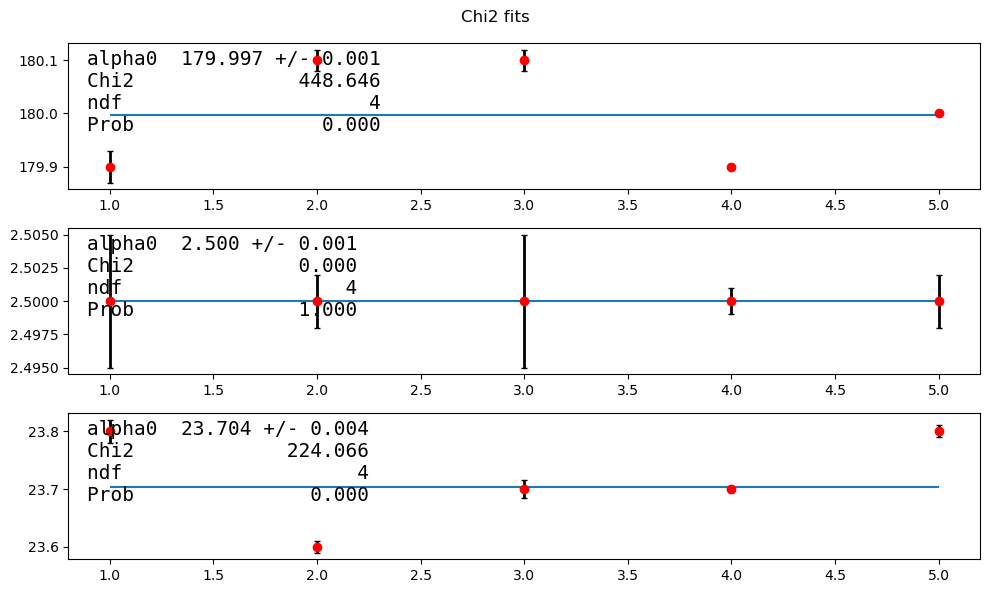

In [152]:
# Now we want to test the Chi-2

array_alpha0 = np.zeros(3)
array_Chi2 = np.zeros(3)
array_Prob = np.zeros(3)
array_sigma_alpha0_fit = np.zeros(3)

Text_array = ['Top to pendulum', 'Pendulum length', 'Floor to pendulum']

fig, axes = plt.subplots(nrows=3,figsize=(10,6))
fig.suptitle(f'Chi2 fits')
for i, y in enumerate(Meassurements):
    Minuit.print_level = 1

    # Fit the data:
    # ------------------------------------------------------------------ #
    # Define a fit function:
    def fit_function(alpha0):
        return alpha0

    x = np.arange(len(y))+1

    # Now we define a ChiSquare to be minimised (using ExternalFunctions):
    chi2_object = Chi2Regression(fit_function, x, y, sM[i])
    chi2_object.errordef = 1.0    # Chi2 definition (for Minuit)

    # Alternatively, you can define Chi2 calculation:
    def chi2_owncalc(alpha0) :
        y_fit = fit_function(alpha0)
        chi2 = np.sum(((y - y_fit) / sM[i])**2)
        return chi2
    chi2_owncalc.errordef = 1.0    # Chi2 definition (for Minuit)

    minuit = Minuit(chi2_owncalc, alpha0=180.0)     # Own alternative

    # Perform the actual fit:
    minuit.migrad();
    
    # Extract the fitting parameters and their errors:
    alpha0_fit = minuit.values['alpha0']
    sigma_alpha0_fit = minuit.errors['alpha0']

    Nvar = 1                     # Number of variables (alpha0 and alpha1)
    Ndof_fit = len(y) - Nvar    # Number of degrees of freedom = Number of data points - Number of variables
    
    # Get the minimal value obtained for the quantity to be minimised (here the Chi2)
    Chi2_fit = minuit.fval                          # The chi2 value
    Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom
    
    # Fill the arrays with fit results (to produce plots of these at the end):
    array_alpha0[i] = alpha0_fit
    array_sigma_alpha0_fit[i] = sigma_alpha0_fit
    array_Chi2[i] = Chi2_fit
    array_Prob[i] = Prob_fit

    ax = axes[i]
    ax.errorbar(x, y, sM[i], fmt='ro', ecolor='k', elinewidth=2, capsize=2, capthick=1)
    ax.hlines(y=fit_function(*minuit.values[:]), xmin=1,xmax=5)     # Note how we can "smartly" input the fit values!
    plt.close()

    d = {'alpha0':   [alpha0_fit, sigma_alpha0_fit],
         'Chi2':     Chi2_fit,
         'ndf':      Ndof_fit,
         'Prob':     Prob_fit,
        }

    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.02, 0.95, text, ax, fontsize=14)
    fig.tight_layout()


fig


In [151]:
# Compute the Length with error from the Chi2 

Len_chi2 = array_alpha0[0] + 0.5*array_alpha0[1]
SLen_chi2 = np.sqrt(array_**2 + (0.5)**2*spend**2)

print(Len_chi2)

181.24654806160325


In [132]:
# Import SymPy: 
from sympy import * 
    
# Define variables:
L,T, gp = symbols("L, T, g_pendulum")
dL,dT,dgp = symbols("sigma_L, sigma_T,sigma_gP")

# Pendulum:
# Define relation, and print:
gp = L * (2 * pi / T)**2 
lprint(latex(Eq(symbols('g_pendulum'),gp)))

# Calculate uncertainty and print:
dgp = sqrt((gp.diff(L) * dL)**2 + (gp.diff(T) * dT)**2)
lprint(latex(Eq(symbols('sigma_gP'), dgp)))

# Turn expression into numerical functions 
fP = lambdify((L,T),gp)
fdP = lambdify((L,dL,T,dT),dgp)

# Define values and their errors
# vL, vdL = mu1,sig1
# vT, vdT = mu2,sig2

vL, vdL = 1.8125,0.0001
vT, vdT = Pendulum_Slope.mean(),stddev
print(vT)
print(vdT)

# Numerically evaluate expressions and print 
vP = fP(vL,vT)
vdP = fdP(vL,vdL,vT,vdT)
lprint(fr'g = ({vP:.3f} \pm {vdP:.3f})\,\mathrm{{m/s^2}}')




# NOTE: Do the above analytical calculation before you continue below! Possibly use SymPy for the differentiations.

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

2.7008275447192736
0.04471288173324876


<IPython.core.display.Latex object>

### Ball on incline
 
- Rolling ball timing and gate positions: Remember, doing (too) many experiments won't decrease the error (why?)!
- Rolling ball acceleration: I.e. combining the above with gate times in quadratic fit.
- Rolling ball diameter and rail distance: Done with a caliper (DK: skydelaerer).
- Rolling ball incline angle: With goniometer (DK: vinkelmaaler) and from trigonometry.
- Rolling ball table angle: Measured by turning the experiment 180 degrees and cross checked by goniometer. Was it consistent with being level?
And finally, you should of course combine your measurements to one value of g for each setup and compare the value and precision with a reference.